# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [8]:
# import libraries
import datetime
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#! pip install pyspark
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import udf, col, concat, count, lit, avg, lag, first, last, when, desc, asc, countDistinct, when, isnan
from pyspark.sql.functions import min as Fmin, max as Fmax, sum as Fsum, round as Fround

from pyspark.sql.types import IntegerType, FloatType, DateType, TimestampType, StringType

from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler

from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier, LinearSVC, LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

from pyspark.ml.regression import LinearRegression


%matplotlib inline

In [27]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("Sparkify") \
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [30]:
path = "mini_sparkify_event_data.json"
sparkify_events = spark.read.json(path)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [31]:
sparkify_events.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [32]:
print("The number of rows is", sparkify_events.count())
print("The number of columns is", len(sparkify_events.columns))

The number of rows is 286500
The number of columns is 18


In [33]:
# Check the unique values of some categories to have an idea of the data
for col in ['auth', 'gender', 'location', 'level', 'method', 'page', 'status', 'registration']:
    print(sparkify_events.groupby(col).count().show(30))

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+

None
+------+------+
|gender| count|
+------+------+
|     F|154578|
|  null|  8346|
|     M|123576|
+------+------+

None
+--------------------+-----+
|            location|count|
+--------------------+-----+
|     Gainesville, FL| 1229|
|Atlantic City-Ham...| 2176|
|Deltona-Daytona B...|   73|
|San Diego-Carlsba...|  754|
|Cleveland-Elyria, OH| 1392|
|Kingsport-Bristol...| 1863|
|New Haven-Milford...| 4007|
|Birmingham-Hoover...|   75|
|  Corpus Christi, TX|   11|
|         Dubuque, IA|  651|
|Las Vegas-Henders...| 2042|
|Indianapolis-Carm...|  970|
|Seattle-Tacoma-Be...|  246|
|          Albany, OR|   23|
|   Winston-Salem, NC|  819|
|     Bakersfield, CA| 1775|
|Los Angeles-Long ...|30131|
|Minneapolis-St. P...| 2134|
|San Francisco-Oak...| 2647|
|Phoenix-Mesa-Scot...| 4846|
|Allentown-Bethleh...|  815|
|Miami-Fort Lauder..

In [34]:
# Print first 2 lines of 'sparkify_events'
sparkify_events.show(n=2, truncate=False, vertical=True)

-RECORD 0------------------------------------------------------------------------------------------------------------------------
 artist        | Martha Tilston                                                                                                  
 auth          | Logged In                                                                                                       
 firstName     | Colin                                                                                                           
 gender        | M                                                                                                               
 itemInSession | 50                                                                                                              
 lastName      | Freeman                                                                                                         
 length        | 277.89016                                                                

### Clean Data

#### Missing values

In [35]:
# Check columns with NaN values
for value in sparkify_events.columns:
    print ("In column (",value,") the number of missing values is", sparkify_events.where(sparkify_events[value].isNull()).count())

In column ( artist ) the number of missing values is 58392
In column ( auth ) the number of missing values is 0
In column ( firstName ) the number of missing values is 8346
In column ( gender ) the number of missing values is 8346
In column ( itemInSession ) the number of missing values is 0
In column ( lastName ) the number of missing values is 8346
In column ( length ) the number of missing values is 58392
In column ( level ) the number of missing values is 0
In column ( location ) the number of missing values is 8346
In column ( method ) the number of missing values is 0
In column ( page ) the number of missing values is 0
In column ( registration ) the number of missing values is 8346
In column ( sessionId ) the number of missing values is 0
In column ( song ) the number of missing values is 58392
In column ( status ) the number of missing values is 0
In column ( ts ) the number of missing values is 0
In column ( userAgent ) the number of missing values is 8346
In column ( userId )

#### Empty values

In [36]:
# Check columns with empty values
for value in sparkify_events.columns:
    print ("In column (",value,") the number of empty values is", sparkify_events.filter(sparkify_events[value] == '').count())

In column ( artist ) the number of empty values is 0
In column ( auth ) the number of empty values is 0
In column ( firstName ) the number of empty values is 0
In column ( gender ) the number of empty values is 0
In column ( itemInSession ) the number of empty values is 0
In column ( lastName ) the number of empty values is 0
In column ( length ) the number of empty values is 0
In column ( level ) the number of empty values is 0
In column ( location ) the number of empty values is 0
In column ( method ) the number of empty values is 0
In column ( page ) the number of empty values is 0
In column ( registration ) the number of empty values is 0
In column ( sessionId ) the number of empty values is 0
In column ( song ) the number of empty values is 0
In column ( status ) the number of empty values is 0
In column ( ts ) the number of empty values is 0
In column ( userAgent ) the number of empty values is 0
In column ( userId ) the number of empty values is 8346


In [37]:
# Delete columns with empty userid
sparkify_events = sparkify_events.filter(sparkify_events.userId != "")

In [38]:
# Check columns with empty values
for value in sparkify_events.columns:
    print ("In column (",value,") the number of empty values is", sparkify_events.filter(sparkify_events[value] == '').count())

In column ( artist ) the number of empty values is 0
In column ( auth ) the number of empty values is 0
In column ( firstName ) the number of empty values is 0
In column ( gender ) the number of empty values is 0
In column ( itemInSession ) the number of empty values is 0
In column ( lastName ) the number of empty values is 0
In column ( length ) the number of empty values is 0
In column ( level ) the number of empty values is 0
In column ( location ) the number of empty values is 0
In column ( method ) the number of empty values is 0
In column ( page ) the number of empty values is 0
In column ( registration ) the number of empty values is 0
In column ( sessionId ) the number of empty values is 0
In column ( song ) the number of empty values is 0
In column ( status ) the number of empty values is 0
In column ( ts ) the number of empty values is 0
In column ( userAgent ) the number of empty values is 0
In column ( userId ) the number of empty values is 0


We got rid of the userId rows that were empty. Now let's take a look at the NaN values

In [40]:
# Check columns with NaN values
for value in sparkify_events.columns:
    print ("In column (",value,") the number of missing values is", sparkify_events.where(sparkify_events[value].isNull()).count())

In column ( artist ) the number of missing values is 50046
In column ( auth ) the number of missing values is 0
In column ( firstName ) the number of missing values is 0
In column ( gender ) the number of missing values is 0
In column ( itemInSession ) the number of missing values is 0
In column ( lastName ) the number of missing values is 0
In column ( length ) the number of missing values is 50046
In column ( level ) the number of missing values is 0
In column ( location ) the number of missing values is 0
In column ( method ) the number of missing values is 0
In column ( page ) the number of missing values is 0
In column ( registration ) the number of missing values is 0
In column ( sessionId ) the number of missing values is 0
In column ( song ) the number of missing values is 50046
In column ( status ) the number of missing values is 0
In column ( ts ) the number of missing values is 0
In column ( userAgent ) the number of missing values is 0
In column ( userId ) the number of mis

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

#### Cancellation Confirmation

In [42]:
# Flag definition for churn (Cancellation Confirmation)
churn_flag = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
sparkify_events = sparkify_events.withColumn("churn", churn_flag("page"))

# Apply churn flag to dataset
window_val = Window.partitionBy("userId")
sparkify_events = sparkify_events.withColumn("churn", Fsum("churn").over(window_val))

In [46]:
# Churned users
sparkify_events["userId", "churn"].dropDuplicates().groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



#### Downgrade Events

In [44]:
# Flag definition for churn (Downgrade)
churn_downgrade = udf(lambda x: 1 if x == "Downgrade" else 0, IntegerType())
sparkify_events = sparkify_events.withColumn("downgrade", churn_downgrade("page"))

# Apply churn flag to dataset
windowval_val = Window.partitionBy("userId")
sparkify_events = sparkify_events.withColumn("downgrade", Fsum("downgrade").over(windowval_val))

In [47]:
# Downgraded users
sparkify_events["userId", "downgrade"].dropDuplicates().groupby("downgrade").count().show()

+---------+-----+
|downgrade|count|
+---------+-----+
|       26|    2|
|       19|    2|
|        0|   71|
|       22|    5|
|        7|    4|
|       50|    1|
|       32|    2|
|       31|    1|
|       39|    1|
|       25|    2|
|        6|    9|
|       68|    1|
|        9|   11|
|       27|    1|
|       17|    2|
|       41|    2|
|       28|    2|
|        5|   12|
|        1|    6|
|       10|    8|
+---------+-----+
only showing top 20 rows



### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Text(0, 0.5, 'Number of interactions')

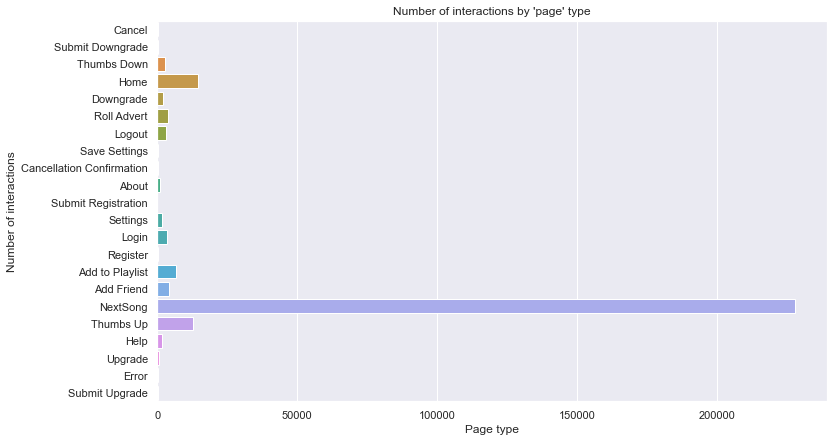

In [48]:
# Checking type of interactions
data = df.groupby("page").count().alias("count").toPandas()
plt.figure(figsize=(12, 7))
sns.set(style="darkgrid")
ax = sns.barplot(x="count", y="page", data=data)
ax.set_title("Number of interactions by 'page' type")
ax.set_xlabel("Page type")
ax.set_ylabel("Number of interactions")

Text(0, 0.5, 'Number of interactions')

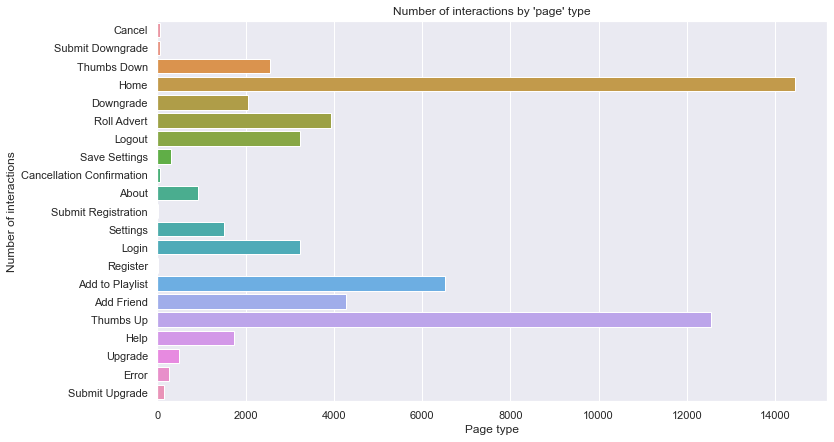

In [49]:
# Checking type of interactions - excluding 'NextSong'
plt.figure(figsize=(12, 7))
sns.set(style="darkgrid")
ax = sns.barplot(x="count", y="page", data=data[data.page!='NextSong'])
ax.set_title("Number of interactions by 'page' type")
ax.set_xlabel("Page type")
ax.set_ylabel("Number of interactions")

In [52]:
# Function to split the date column
def split_date(df, column):
    '''
    INPUT:
    df - the dataframe that contains a column with date data to be split
    column - the name of the column have the date to be split
    OUTPUT:
    df[column+year/month/day/dayofweek] - new columns will be added to the dataframe with the date split
    
    Takes the date from the column specified and split it into year, month, day and dayofweek 
    and then this data is added to the existing input dataframe
    '''
    df[column+'_hour'] = df[column].apply(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
    df[column+'_day'] = df[column].apply(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
    df[column+'_dayofweek'] = df[column].apply(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
    
    
# date column split
sparkify_date = sparkify_events.toPandas()
split_date(sparkify_date, 'ts')

In [53]:
sparkify_date.head(2)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,song,status,ts,userAgent,userId,churn,downgrade,ts_hour,ts_day,ts_dayofweek
0,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,Captain Tyin Knots VS Mr Walkway (No Way),200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,14,8,1
1,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,Beautiful_ Beautiful (Album),200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,15,8,1


In [55]:
cancel_sparkify_date = sparkify_date[sparkify_date['page']=='Cancellation Confirmation']
cancel_sparkify_date=cancel_sparkify_date[["ts","registration"]]
cancel_sparkify_date['ts']=cancel_sparkify_date['ts'].apply(lambda row: datetime.datetime.fromtimestamp(row / 1000.0))
cancel_sparkify_date['registration']= cancel_sparkify_date['registration'].apply(lambda row: datetime.datetime.fromtimestamp(row / 1000.0))

cancel_sparkify_date['diff_days'] = cancel_sparkify_date['ts'] - cancel_sparkify_date['registration']
cancel_sparkify_date['diff_days']= cancel_sparkify_date['diff_days']/np.timedelta64(1,'D')

In [57]:
# Average days until cancellation
print("-> Average days until cancellation:", cancel_sparkify_date["diff_days"].mean())

-> Average days until cancellation: 57.28756343482909


Text(0, 0.5, 'Churn')

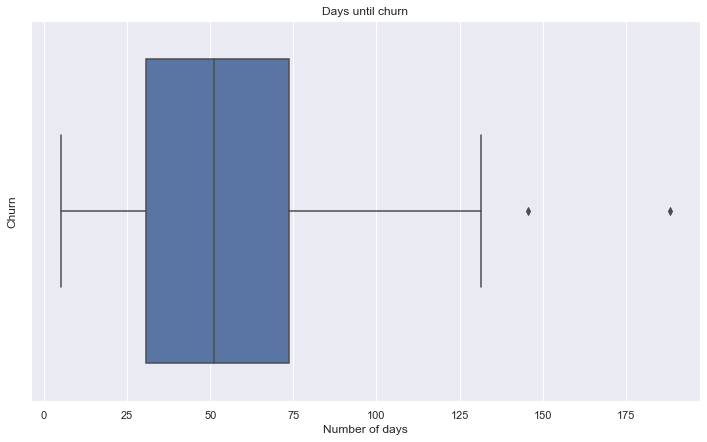

In [63]:
# Ploting
plt.figure(figsize=(12, 7))
sns.set(style="darkgrid")
ax = sns.boxplot(x='diff_days', orient="h", data=cancel_sparkify_date)
ax.set_title("Days until churn")
ax.set_xlabel("Number of days")
ax.set_ylabel("Churn")

In [71]:
# Churn rates by Gender
churn_gender = sparkify_events.groupby('gender', 'churn').agg(countDistinct('userId')).toPandas().rename(columns = {'count(userId)':'num_of_users'})
churn_gender.head(2)

,gender,churn,num_of_users
0,F,0,84
1,F,1,20


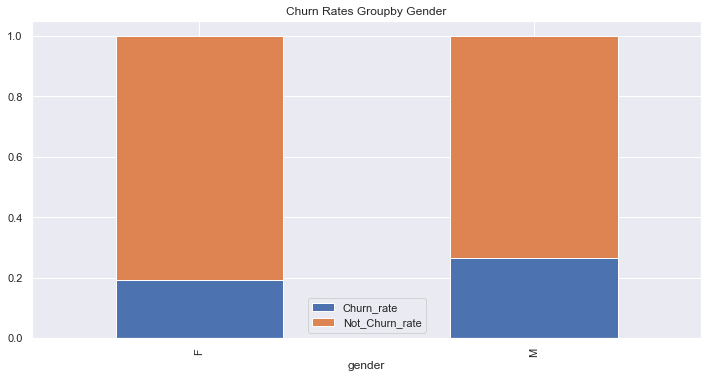

In [82]:
# Churn rates by Gender
churn_gender = sparkify_events.groupby('gender', 'churn').agg(countDistinct('userId')).toPandas().rename(columns = {'count(userId)':'num_of_users'})\
       .pivot(index = 'gender', columns = 'churn', values = 'num_of_users').\
           rename(columns = {0:'Not Churn', 1:'Churn'})

churn_gender['All']= churn_gender['Not Churn'] + churn_gender['Churn']
churn_gender['Churn_rate'] = churn_gender['Churn'] / churn_gender['All']
churn_gender['Not_Churn_rate'] = 1 - churn_gender['Churn_rate']

fig = plt.figure(figsize = (10, 10))
ax1 = fig.add_subplot(2,1,2)
churn_gender[['Churn_rate','Not_Churn_rate']].plot(kind = 'bar', ax = ax1, stacked = True)
plt.title('Churn Rates Groupby Gender')
plt.legend(loc = 'best')
plt.tight_layout()

#### 'Thumbs up' per sessionId - page

In [85]:
# Number of interactions - thumbs up per sessionId - by churn type
data = sparkify_events.filter(sparkify_events['page'] == 'Thumbs Up').groupby("userId", "churn", "sessionId").count().toPandas()

Text(0, 0.5, 'Churn')

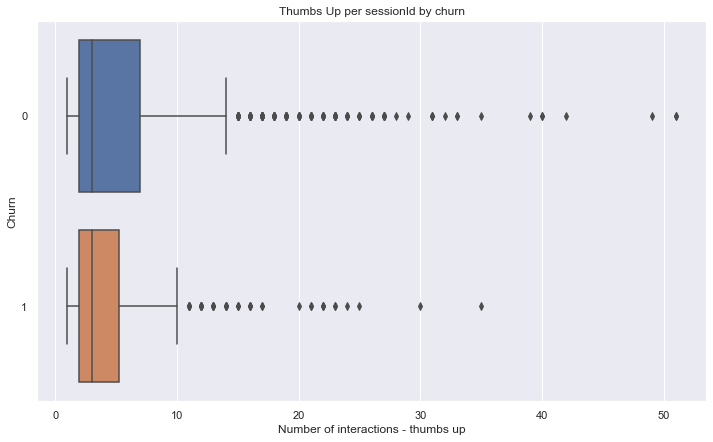

In [86]:
# Ploting
plt.figure(figsize=(12, 7))
sns.set(style="darkgrid")
ax = sns.boxplot(x='count', y='churn', orient="h", data=data)
ax.set_title("Thumbs Up per sessionId by churn")
ax.set_xlabel("Number of interactions - thumbs up")
ax.set_ylabel("Churn")

#### 'Add Friend' per sessionId - page

In [87]:
# Number of interactions - thumbs up per sessionId - by churn type
data = sparkify_events.filter(sparkify_events['page'] == 'Add Friend').groupby("userId", "churn", "sessionId").count().toPandas()

Text(0, 0.5, 'Churn')

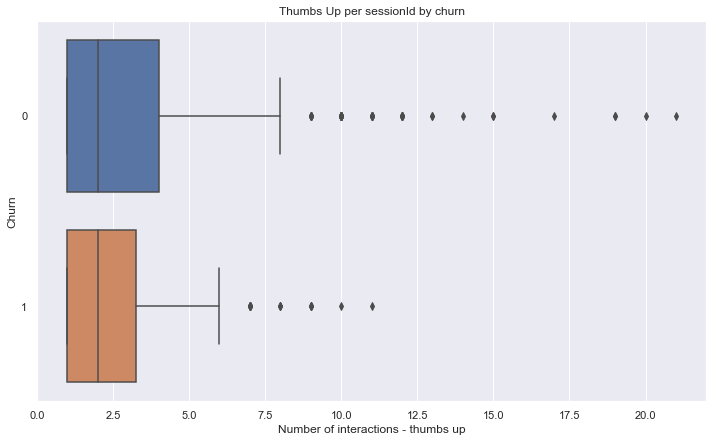

In [88]:
# Ploting
plt.figure(figsize=(12, 7))
sns.set(style="darkgrid")
ax = sns.boxplot(x='count', y='churn', orient="h", data=data)
ax.set_title("Thumbs Up per sessionId by churn")
ax.set_xlabel("Number of interactions - thumbs up")
ax.set_ylabel("Churn")

#### 'Help' per sessionId - page

In [97]:
# Number of interactions - thumbs up per sessionId - by churn type
data = sparkify_events.filter(sparkify_events['page'] == 'Help').groupby("userId", "churn", "sessionId").count().toPandas()
data

,userId,churn,sessionId,count
0,100010,0,113,1
1,100010,0,133,1
2,200002,0,163,1
3,200002,0,205,1
4,124,0,123,1
...,...,...,...,...
925,200021,1,137,1
926,200021,1,171,1
927,200021,1,276,1
928,119,0,1129,3


Text(0, 0.5, 'Churn')

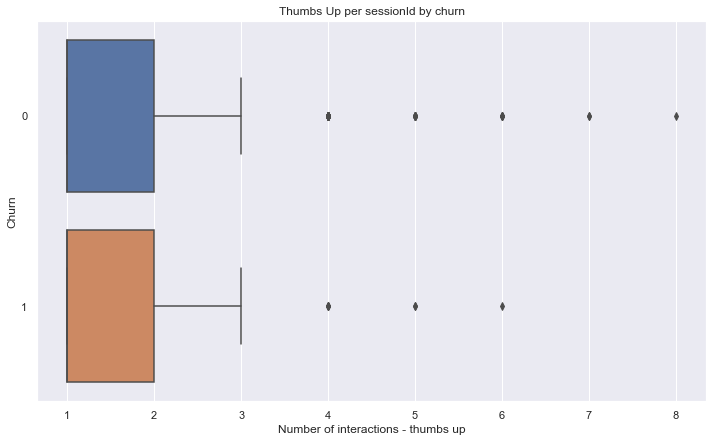

In [92]:
# Ploting
plt.figure(figsize=(12, 7))
sns.set(style="darkgrid")
ax = sns.boxplot(x='count', y='churn', orient="h", data=data)
ax.set_title("Thumbs Up per sessionId by churn")
ax.set_xlabel("Number of interactions - thumbs up")
ax.set_ylabel("Churn")

In [ ]:
# Create var 'Churn'
churn_users = sparkify_events.select('userId').where(sparkify_events.page == 'Cancellation Confirmation').distinct().\
                    withColumn('is_churn', lit(1))
sparkify_event_churn = sparkify_event_data.join(churn_users, on = 'userId', how = 'left')
sparkify_event_churn = sparkify_event_churn.fillna({'is_churn':0})
sparkify_event_churn.groupby('is_churn').agg(countDistinct('userId')).show()

In [103]:
# count num of spefific pagesviews per user
page_cnts = spark.createDataFrame(sparkify_events.groupby('userId', 'page').count().toPandas().\
                        pivot(index = 'userId', columns = 'page', values = 'count').reset_index().\
                                 rename(columns = {'Add Friend':'Add_Friend', 'Roll Advert':'Roll_Advert', 'Thumbs Down':'Thumbs_Down',\
                                                    'Thumbs Up':'Thumbs_Up'}))
page_cnts = page_cnts.select('userId','Add_Friend', 'Downgrade', 'Upgrade', 'Error', 'Help', 'Logout', 'NextSong', \
                             'Roll_Advert', 'Thumbs_Down', 'Thumbs_Up')

In [104]:
# Add most frequent device
get_device = udf(lambda x: x.split('(')[1].split(';')[0].split(' ')[0])
sparkify_event_churn = sparkify_events.withColumn("device", get_device(sparkify_events.userAgent))
device_cnts = sparkify_event_churn.groupby('userId', 'device').count().toPandas()
device_cnts = spark.createDataFrame(device_cnts.sort_values(['userId','count']).\
                                    drop_duplicates(subset = 'userId', keep = 'last'))

In [107]:
# merge dataset
data = page_cnts.join(device_cnts, on = 'userId', how = 'left')

num_of_events = {} 
for col in ['artist','page','sessionId','song']:  
        num_of_events[col] = sparkify_events.groupby('userId').agg(countDistinct(col))

for v in num_of_events.values():
        data = data.join(v, on = 'userId', how = 'left')
data = data.withColumnRenamed('count(DISTINCT artist)', 'num_artists') \
            .withColumnRenamed('count(DISTINCT page)', 'num_pages') \
            .withColumnRenamed('count(DISTINCT sessionId)', 'num_sessions') \
            .withColumnRenamed('count(DISTINCT song)', 'num_songs')
data = data.fillna(0)
data = data.drop('count')

In [109]:
data.toPandas()
data.head(5)

[Row(userId='100010', Add_Friend=4.0, Downgrade=0.0, Upgrade=2.0, Error=0.0, Help=2.0, Logout=5.0, NextSong=275.0, Roll_Advert=52.0, Thumbs_Down=5.0, Thumbs_Up=17.0, device='iPhone', count(artist)=252, count(page)=11, count(sessionId)=7, count(song)=269),
 Row(userId='200002', Add_Friend=4.0, Downgrade=5.0, Upgrade=2.0, Error=0.0, Help=2.0, Logout=5.0, NextSong=387.0, Roll_Advert=7.0, Thumbs_Down=6.0, Thumbs_Up=21.0, device='iPhone', count(artist)=339, count(page)=14, count(sessionId)=6, count(song)=378),
 Row(userId='125', Add_Friend=0.0, Downgrade=0.0, Upgrade=0.0, Error=0.0, Help=0.0, Logout=0.0, NextSong=8.0, Roll_Advert=1.0, Thumbs_Down=0.0, Thumbs_Up=0.0, device='Macintosh', count(artist)=8, count(page)=4, count(sessionId)=1, count(song)=8),
 Row(userId='124', Add_Friend=74.0, Downgrade=41.0, Upgrade=0.0, Error=6.0, Help=23.0, Logout=59.0, NextSong=4079.0, Roll_Advert=4.0, Thumbs_Down=41.0, Thumbs_Up=171.0, device='Macintosh', count(artist)=2232, count(page)=14, count(sessionId)=

In [110]:
# Ploting
plt.figure(figsize=(12, 7))
sns.set(style="darkgrid")
ax = sns.boxplot(x='Help', y='churn', orient="h", data=data)
ax.set_title("Thumbs Up per sessionId by churn")
ax.set_xlabel("Number of interactions - thumbs up")
ax.set_ylabel("Churn")

AttributeError: 'DataFrame' object has no attribute 'get'

<Figure size 864x504 with 0 Axes>

KeyError: 'churn'

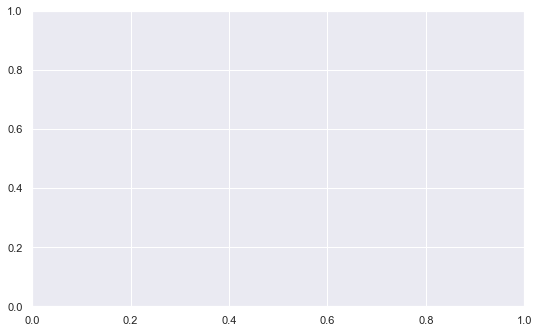

In [112]:
# events vs churn
event_categories = ['Add_Friend','Downgrade','Upgrade','Error','Help',\
                    'Logout','NextSong','Roll_Advert','Thumbs_Down','Thumbs_Up']
data_df = data.toPandas()
fig = plt.figure(figsize = (30, 25))
for i, col in enumerate(event_categories):
    ax = fig.add_subplot(4,3,i+1)
    data_df.boxplot(col, ax = ax, grid = False, by = 'churn', fontsize = 'large', showfliers=False)
fig.suptitle('')
plt.tight_layout()
plt.show()

#### 'Next Song' per sessionId - page

In [102]:
# Number of interactions - thumbs up per sessionId - by churn type
data = sparkify_events.filter(sparkify_events['page'] == 'NextSong').groupby("userId", "churn", "sessionId").count().toPandas()

Text(0, 0.5, 'Churn')

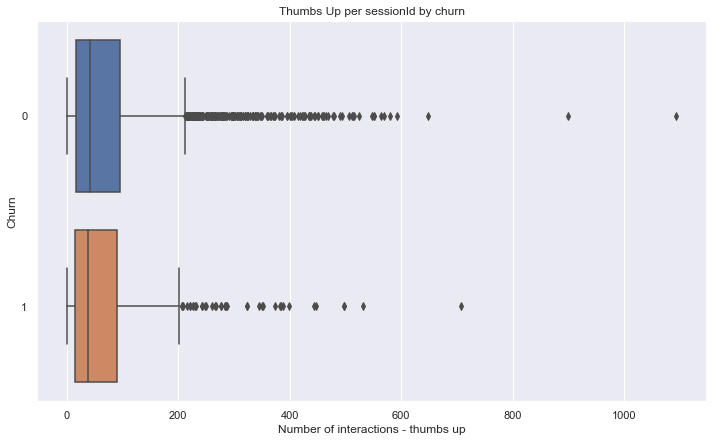

In [100]:
# Ploting
plt.figure(figsize=(12, 7))
sns.set(style="darkgrid")
ax = sns.boxplot(x='count', y='churn', orient="h", data=data)
ax.set_title("Thumbs Up per sessionId by churn")
ax.set_xlabel("Number of interactions - thumbs up")
ax.set_ylabel("Churn")

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.